### 목차
1. 라이브러리 불러오기 및 데이터 확인하기  
    1.1  라이브러리 불러오기  
    1.2. 데이터 확인하기  
2. 데이터 전처리  
    2.1. 불필요한 특수문자 등 제거  
    2.2. 토크나이징 : '질문'+'$'+'답변'  
3. 모델 구성하기  
    3.1. 디코더 레이어 정의 : GPT-1 디코더 레이어(Masked Multi Self-attention 외)
    3.2. 디코더 레이어 정의 : GPT-1 디코더 전체 구성
    3.3. GPT1모델 구성하기 (입출력 정의)  
4. 하이퍼파라미터 & 모델정의  
5. 모델학습  
    5.1 손실 및 정확도 함수  
    5.2 학습 과정에서 손실 및 정확도 모니터링  


---

### 1.1 라이브러리 불러오기

In [1]:
# 1.1 텐서플로우 및 케라스
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1.2 데이터 전처리 및 시각화 도구 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import re
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

### 1.2. 데이터 확인하기

데이터를 불러오고 확인하는 과정을 진행하였다. 


In [2]:
data = pd.read_csv(os.getenv("HOME")+"/aiffel/AIFFEL_quest_rs/AIFFEL_quest_rs/Exploration/Ex07/ChatbotData.csv")
data_org = data.copy()

In [3]:
print('전체 샘플수 :', (len(data_org)))
data.sample(10) 

전체 샘플수 : 11823


,Q,A,label
1289,돈 모으는 재미,부자되실 거예요!,0
857,내가 이상한가?,지극히 평범하면서 지극히 특별하죠.,0
8720,헤어짐과 중간에 다시 만남과 갈등.,매정하게 돌아서는 것은 쉽지 않은 일이죠.,1
844,내가 부족하니까 이렇게 밖에 안된거겠지.,인생은 채워나가는거죠.,0
10585,여자친구가 다른남자들에게 인기가 많은게 고민이야.,인기 많은 여자친구가 있어 더 좋을 거 같은데요.,2
8962,결혼적령기가 지나면 결혼하기 힘들겠지?,내가 결혼할 때가 결혼적령기예요.,2
4277,지갑 잃어버림,잘 찾아보세요.,0
5478,걸지 못한 전화,걸지 말아요.,1
3369,오랜만에 서점에 갔었어,마음의 양식을 채우길 바랄세요.,0
1390,딸기 먹어야지,맛있게 드세요.,0


**결측치, 중복값 확인**

In [4]:
# 결측치 확인
print('컬럼별 결측치 개수 : ','\n',data.isnull().sum(),'\n')

# 중복값 확인
print('중복값 개수 : ',data.duplicated().sum())

컬럼별 결측치 개수 :  
 Q        0
A        0
label    0
dtype: int64 

중복값 개수 :  0


- **결측치는 없었고 중복데이터 역시 없었다.**


**MAX LENGTH설정을 위한 컬럼별 최대, 최소 길이 확인**

In [5]:
Q_len = [len(s.split()) for s in data['Q']]
A_len = [len(s.split()) for s in data['A']]

print('질문의 최소 길이 : {}'.format(np.min(Q_len)))
print('질문의 최대 길이 : {}'.format(np.max(Q_len)))
print('질문의 평균 길이 : {}'.format(np.mean(Q_len)))
print('답변의 최소 길이 : {}'.format(np.min(A_len)))
print('답변의 최대 길이 : {}'.format(np.max(A_len)))
print('답변의 평균 길이 : {}'.format(np.mean(A_len)))

질문의 최소 길이 : 1
질문의 최대 길이 : 15
질문의 평균 길이 : 3.587414361837097
답변의 최소 길이 : 1
답변의 최대 길이 : 21
답변의 평균 길이 : 3.6936479742874058


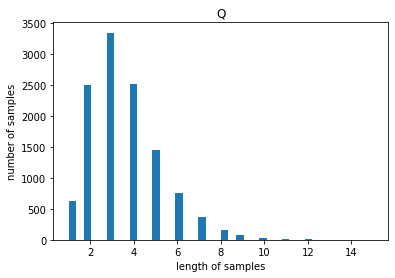

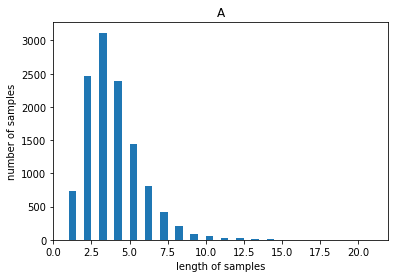

In [6]:
plt.title('Q')
plt.hist(Q_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('A')
plt.hist(A_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- **MAX LENGTH의 초기값은, 두 컬럼 모두 '10'로 정함.** 

**신조어(?)확인**

In [7]:
# "Q" 컬럼에 "ㅠ", "ㅎ", "ㅋ"가 포함된 셀들이 있는지 유무 확인
contains_Qa = data["Q"].str.contains("ㅠ").any()
contains_Qb = data["Q"].str.contains("ㅎ").any()
contains_Qc = data["Q"].str.contains("ㅋ").any()
# "A" 컬럼에 "ㅠ", "ㅎ", "ㅋ"가 포함된 셀들이 있는지 유무 확인
contains_Aa = data["Q"].str.contains("ㅠ").any()
contains_Ab = data["Q"].str.contains("ㅎ").any()
contains_Ac = data["Q"].str.contains("ㅋ").any()

print(f'컬럼Q에 "ㅠ"가 포함된 셀이 있나요? {contains_Qa}')
print(f'컬럼Q에 "ㅎ"가 포함된 셀이 있나요? {contains_Qb}')
print(f'컬럼Q에 "ㅋ"가 포함된 셀이 있나요? {contains_Qc}')
print()                                 
print(f'컬럼A에 "ㅠ"가 포함된 셀이 있나요? {contains_Aa}')
print(f'컬럼A에 "ㅎ"가 포함된 셀이 있나요? {contains_Ab}')
print(f'컬럼A에 "ㅋ"가 포함된 셀이 있나요? {contains_Ac}')

컬럼Q에 "ㅠ"가 포함된 셀이 있나요? True
컬럼Q에 "ㅎ"가 포함된 셀이 있나요? True
컬럼Q에 "ㅋ"가 포함된 셀이 있나요? True

컬럼A에 "ㅠ"가 포함된 셀이 있나요? True
컬럼A에 "ㅎ"가 포함된 셀이 있나요? True
컬럼A에 "ㅋ"가 포함된 셀이 있나요? True


- **두 컬럼에 'ㅋ', 'ㅎ', 'ㅠ' 등 문자열 있는 지 확인하였다**
=> 있는 것 확인하여서 아래 전처리 진행 할 것.

---

### 2.1. 데이터 전처리 :불필요한 특수문자 등 제거

In [8]:
# 전처리 함수
def preprocess_sentence(sentence):
  # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
  sentence = sentence.lower().strip()  

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (가나다, a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^A-Za-z0-9가-힣]+", " ", sentence) 
  sentence = sentence.strip()

  # 다중공백 단일화  
  sentence = re.sub(r'[" "]+', " ", sentence)  
    
  # (ㅋ, ㅎ , ㅠ)정규화
  sentence = re.sub(r"ㅋ{2,}", "ㅋㅋ", sentence) # 연속된 'ㅋ'를 통일
  sentence = re.sub(r"ㅎ{2,}", "ㅎㅎ", sentence) # 연속된 'ㅎ'를 통일
  sentence = re.sub(r"ㅠ{2,}", "ㅠㅠ", sentence) # 연속된 'ㅠ'를 통일 
    
  return sentence

### 2.2 데이터전처리 : 토크나이징 : '질문'+ '$'+'답변'

In [9]:
# 질문 + 답변 구조를 반영한 데이터 전처리
def preprocess_data_for_question_answering(data, tokenizer, max_length_q, max_length_a, start_token, end_token):
    processed_inputs = []
    processed_outputs = []
    
    for idx, row in data.iterrows():
        question = preprocess_sentence(row['Q'])  # 질문 (question)
        answer = preprocess_sentence(row['A'])  # 답변 (answer)
        
        # 질문과 답변 각각 토큰화
        tokenized_question = tokenizer.encode(question)
        tokenized_answer = tokenizer.encode(answer)
        
        # 질문에 START_TOKEN 추가
        input_sequence = [start_token] + tokenized_question + [end_token]
        # 답변에 START_TOKEN 추가 (모델이 처음 입력받을 시퀀스)
        output_sequence = [start_token] + tokenized_answer + [end_token]
        
        processed_inputs.append(input_sequence)
        processed_outputs.append(output_sequence)
    
    # 질문과 답변 각각 패딩 추가
    padded_inputs = pad_sequences(processed_inputs, maxlen=max_length_q + 2, padding='post')
    padded_outputs = pad_sequences(processed_outputs, maxlen=max_length_a + 2, padding='post')
    
    return padded_inputs, padded_outputs

In [10]:
# 질문 + 답변 구조를 반영한 데이터 전처리 및 데이터 분리
def preprocess_and_split_data(data, tokenizer, max_length_q, max_length_a, start_token, end_token, test_size=0.2, random_state=42):
    inputs, outputs = preprocess_data_for_question_answering(data, tokenizer, max_length_q, max_length_a, start_token, end_token)
    
    # Train/Test 데이터 분리
    train_inputs, test_inputs, train_outputs, test_outputs = train_test_split(
        inputs, outputs, test_size=test_size, random_state=random_state
    )
    
    return train_inputs, test_inputs, train_outputs, test_outputs


In [11]:
def create_tf_dataset(inputs, outputs, batch_size):
    # tf.data.Dataset을 사용해 데이터셋 생성
    dataset = tf.data.Dataset.from_tensor_slices(({'inputs': inputs}, {'outputs': outputs[:, 1:]}))
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [12]:
# 토크나이저를 사용하여 데이터 전처리 및 데이터셋 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (preprocess_sentence(row['Q']) + preprocess_sentence(row['A']) for idx, row in data.iterrows()), 
    target_vocab_size=2**13)

START_TOKEN, END_TOKEN = tokenizer.vocab_size, tokenizer.vocab_size + 1
VOCAB_SIZE = tokenizer.vocab_size + 2
MAX_LENGTH_Q = 10  # 질문에 대한 최대 길이
MAX_LENGTH_A = 10  # 답변에 대한 최대 길이
BATCH_SIZE = 64

In [13]:
# Train/Test 데이터 분리 및 전처리된 데이터셋 생성
train_inputs, test_inputs, train_outputs, test_outputs = preprocess_and_split_data(data, tokenizer, MAX_LENGTH_Q, MAX_LENGTH_A, START_TOKEN, END_TOKEN)

# Train/Test TensorFlow 데이터셋 생성
train_dataset = create_tf_dataset(train_inputs, train_outputs, BATCH_SIZE)
test_dataset = create_tf_dataset(test_inputs, test_outputs, BATCH_SIZE)

In [15]:
# 출력 확인 (첫 번째 데이터 확인)
for inputs, outputs in train_dataset.take(1):
    print(inputs['inputs'][0].numpy())
    # print(inputs['dec_inputs'][0].numpy())
    print(outputs['outputs'][0].numpy())

[8504  430 7602   56 8505    0    0    0    0    0    0    0]
[2976  595 4823  835 8505    0    0    0    0    0    0]


---

## 3. 모델 구성하기

---

In [16]:
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # tf.stack을 self 없이 사용
        pos_encoding = tf.stack([sines, cosines], axis=-1)
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        # pos_encoding을 batch 차원 추가
        pos_encoding = pos_encoding[tf.newaxis, ...]

        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        # 입력에 Positional Encoding을 더함
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("PositionalEncoding")

PositionalEncoding


In [17]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  # 쿼리 Q, 키 K, 값 V에 대한 Scaled Dot Product Attention 계산
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  # (디멘션 크기의 제곱근으로 나누어 스케일링)
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가 
  # (마스크 적용시,마스크된 위치는 매우 작은 음수로 설정)
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  # (소프트맥스를 사용해 유사도 값을 확률로 변환)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  # (값 V에 가중치를 적용하여 최종 Attention 결과 계산)
  output = tf.matmul(attention_weights, value)
  return output

print("scaled_dot_product_attention")

scaled_dot_product_attention


In [18]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query) # [[YOUR CODE]]
    key = self.key_dense(key) # [[YOUR CODE]]
    key = self.value_dense(key) # [[YOUR CODE]]

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query =self.split_heads(query,batch_size) # [[YOUR CODE]]
    key =self.split_heads(key,batch_size) # [[YOUR CODE]]
    value =self.split_heads(value,batch_size) # [[YOUR CODE]]

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs
print("Multi-Head Self-Attention")

Multi-Head Self-Attention


In [19]:
# 패딩 마스킹(Padding Masking)
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("create_padding_mask")

create_padding_mask


In [20]:
# 룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("create_look_ahead_mask")

create_look_ahead_mask


### 3.1. 디코더 레이어 정의 : GPT-1 디코더 레이어
**(Masked Multi Self-attention 외)**

In [21]:
# GPT-1 디코더 레이어 정의
def gpt1_decoder_layer(units, d_model, num_heads, dropout, name="gpt1_decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")

    # Masked Multi-head Self-attention
    attention1 = MultiHeadAttention(d_model, num_heads, name="attention_1")(
        inputs={'query': inputs, 'key': inputs, 'value': inputs, 'mask': look_ahead_mask}
    )
    # Layer norm after masked self-attention
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # Position-wise feed forward network
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention1)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    # Layer norm after feed forward
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention1)

    return tf.keras.Model(inputs=[inputs, look_ahead_mask], outputs=outputs, name=name)


### 3.2. 디코더 레이어 정의 : GPT-1 디코더 전체 구성

In [22]:
# GPT-1 디코더 전체 구성
def gpt1_decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name='gpt1_decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    # 임베딩 및 포지셔널 인코딩
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 디코더 레이어 반복
    for i in range(num_layers):
        outputs = gpt1_decoder_layer(units=units, d_model=d_model, num_heads=num_heads, dropout=dropout,
                                     name=f'decoder_layer_{i}')([outputs, look_ahead_mask])

    return tf.keras.Model(inputs=[inputs, look_ahead_mask], outputs=outputs, name=name)


### 3.3. GPT1모델 구성하기 (입출력 정의)  

In [23]:
# GPT-1 전체 모델 구성
# GPT-1 모델의 입력 정의 (디코더 기반)
def gpt1_model(vocab_size, num_layers, units, d_model, num_heads, dropout):
    inputs = tf.keras.Input(shape=(None,), name="inputs")  # 디코더 입력
    look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask, output_shape=(1, None, None), name='look_ahead_mask')(inputs)

    # 디코더 블록
    dec_outputs = gpt1_decoder(vocab_size=vocab_size, num_layers=num_layers, units=units, d_model=d_model, num_heads=num_heads, dropout=dropout)(
        inputs=[inputs, look_ahead_mask])
    
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs], outputs=outputs, name="gpt1_model")



---

## 4. 하이퍼파라미터 & 모델정의

---

**하이퍼파라미터**

In [24]:
tf.keras.backend.clear_session()

# 하이퍼파라미터 설정 #01
num_layers = 6
d_model = 256
num_heads = 8
units = 512
dropout = 0.1

**모델정의**

In [34]:
# GPT-1 모델 생성
model = gpt1_model(VOCAB_SIZE, num_layers, units, d_model, num_heads, dropout)

---

## 5. 모델학습

---

### 5.1 손실 및 정확도 함수 정의

**손실함수**

In [26]:
# 손실 함수 (Custom Loss Function)
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

# 커스텀 학습률 (Custom Learning Rate Schedule)
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


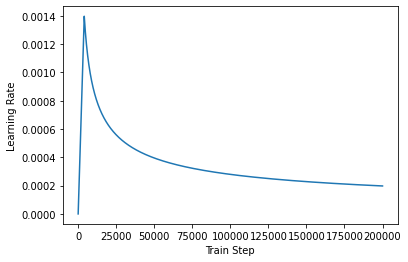

In [27]:
# 커스텀 학습률 시각화
sample_learning_rate = CustomSchedule(d_model=128)
plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.show()

**정확도 함수**

In [28]:
# 학습률 설정 및 옵티마이저 정의
learning_rate = CustomSchedule(d_model=128)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# 정확도 메트릭 정의 (Accuracy)
def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return [tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)]

---

### 5.2 학습 과정에서 손실 및 정확도 모니터링

**모델 학습 설정하기 하기**

In [29]:
model.compile(optimizer=optimizer, loss=loss_function, metrics=accuracy)
model.summary()

Model: "gpt1_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
look_ahead_mask (Lambda)        (None, 1, None, None 0           inputs[0][0]                     
__________________________________________________________________________________________________
gpt1_decoder (Functional)       (None, None, 256)    5340160     inputs[0][0]                     
                                                                 look_ahead_mask[0][0]            
__________________________________________________________________________________________________
outputs (Dense)                 (None, None, 8506)   2186042     gpt1_decoder[0][0]      

**모델 실제 학습하기**

In [31]:
# 교사 강요 적용한 데이터셋 생성
def create_tf_dataset(inputs, outputs, batch_size, max_length):
    # 입력과 출력의 길이를 맞추기 위해 max_length 적용
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=max_length, padding='post')
    outputs = tf.keras.preprocessing.sequence.pad_sequences(outputs, maxlen=max_length, padding='post')

    dataset = tf.data.Dataset.from_tensor_slices(({'inputs': inputs[:, :-1]}, {'outputs': outputs[:, 1:]}))
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset



# Train/Test TensorFlow 데이터셋 생성
train_dataset = create_tf_dataset(train_inputs, train_outputs, BATCH_SIZE, MAX_LENGTH)
test_dataset = create_tf_dataset(test_inputs, test_outputs, BATCH_SIZE, MAX_LENGTH)


In [32]:
MAX_LENGTH = 20
EPOCHS = 5
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습 (dec_inputs 없이)
history = model.fit(train_dataset, epochs=EPOCHS, validation_data=test_dataset, callbacks=[early_stopping], verbose=1)


Epoch 1/5


TypeError: 'NoneType' object is not callable

---

### 5.3. 평가하기 

In [ ]:
def evaluate(sentence):
    # 입력 문장을 전처리
    sentence = preprocess_sentence(sentence)

    # 입력 문장을 토큰화하고, 시작과 끝 토큰 추가
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 패딩 마스킹 생성
    padding_mask = create_padding_mask(sentence)

    # 시작 토큰을 디코더의 첫 번째 입력으로 사용
    output = tf.expand_dims(START_TOKEN, 0)

    # 디코더가 종료 토큰을 예측하거나 최대 길이에 도달할 때까지 반복
    for i in range(MAX_LENGTH):
        # 예측을 위한 입력 준비 (인코더와 디코더에 넣어줌)
        predictions = model(inputs=[sentence, output], training=False)

        # 마지막 단어를 선택
        predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

        # 예측한 단어의 ID
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 종료 토큰을 예측하면 반복을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어를 출력에 추가
        output = tf.concat([output, predicted_id], axis=-1)

    # 예측된 토큰을 문장으로 변환
    predicted_sentence = tokenizer.decode([i for i in tf.squeeze(output, axis=0) if i < tokenizer.vocab_size])

    return predicted_sentence

# 예측을 위한 함수
def predict(sentence):
    prediction = evaluate(sentence)
    return prediction

## RESULT : TRAIL#01

In [ ]:
# TRAIL #01 테스트를 위한 문장 입력
test_sentence = "오늘 날씨가 어때?"
prediction = predict(test_sentence)
print(f'입력 문장: {test_sentence}')
print(f'예측된 답변: {prediction}')

**모델러 평가**  
=>

In [ ]:
# TRAIL #0 테스트를 위한 문장 입력

**모델러 평가**  
=>

In [ ]:
# TRAIL #0 테스트를 위한 문장 입력

**모델러 평가**  
=>